### Imports

In [2]:
import pandas as pd
import utils
import numpy as np
from astropy.timeseries import BoxLeastSquares
import matplotlib.pyplot as plt
import lightkurve as lk
from scipy.signal import medfilt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve, f1_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression  

### Read in Lightcurve Data

In [3]:
# from csv file created using utils.collect_curves_tofiles()
all_curves = pd.read_csv('./Data/flux_200_1000_50.csv', header = None)
all_times = pd.read_csv('./Data/time_200_1000_50.csv', header = None)
all_labels = pd.read_csv('./Data/labels_200_1000_50.csv', header = None)
all_labels = np.array(all_labels).ravel()

# train-val-test split
X_trainval, X_test, y_trainval, y_test = train_test_split(all_curves, all_labels, test_size=0.333, random_state=321)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.5, random_state=321)

# fill in Nans
X_train_interp = X_train.interpolate(limit_direction='both', axis = 1)
X_val_interp = X_val.interpolate(limit_direction='both', axis = 1)
X_test_interp = X_test.interpolate(limit_direction='both', axis = 1)

# Algorithm 1: K Nearest Neighbors

### Determine best hyperparameters

Optimal value: 6


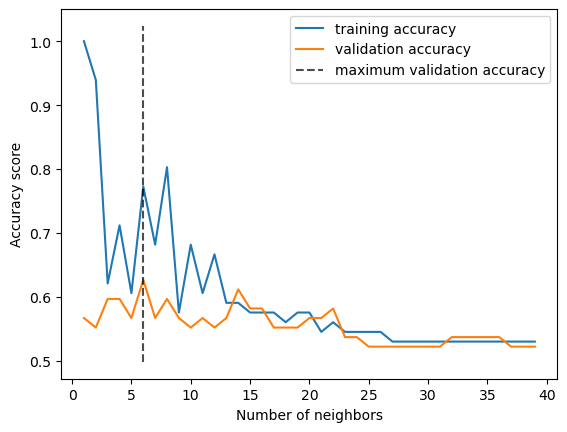

In [4]:
train_acc = []
val_acc = []
n = np.arange(1,40,1)
for n_neighbors in n:
    knn = KNeighborsClassifier(n_neighbors)
    knn.fit(X_train_interp, y_train.ravel())
    knn_pred_val = knn.predict(X_val_interp)
    knn_pred_train = knn.predict(X_train_interp)
    val_acc += [accuracy_score(y_val, knn_pred_val)]
    train_acc += [accuracy_score(y_train, knn_pred_train)]
    
# determine 'best' n_neighbors
best_n_neighbors = int(n[np.where(val_acc == np.max(val_acc))])
print('Optimal value: ' + str(best_n_neighbors))
plt.figure(dpi = 100)
plt.plot(n,train_acc, label = 'training accuracy')
plt.plot(n,val_acc,label = 'validation accuracy')
ylims = plt.gca().get_ylim()
plt.vlines(best_n_neighbors, ylims[0], ylims[1], 'k', alpha = 0.7, linestyle = 'dashed', label = 'maximum validation accuracy')
plt.ylabel('Accuracy score')
plt.xlabel('Number of neighbors')
plt.legend()

### Train the model using best hyperparameters

Validation Data:
   Accuracy: 0.627
   Precision: 0.639
   Recall: 0.657
   F1: 0.648
Test Data:
   Accuracy: 0.567
   Precision: 0.522
   Recall: 0.4
   F1: 0.453


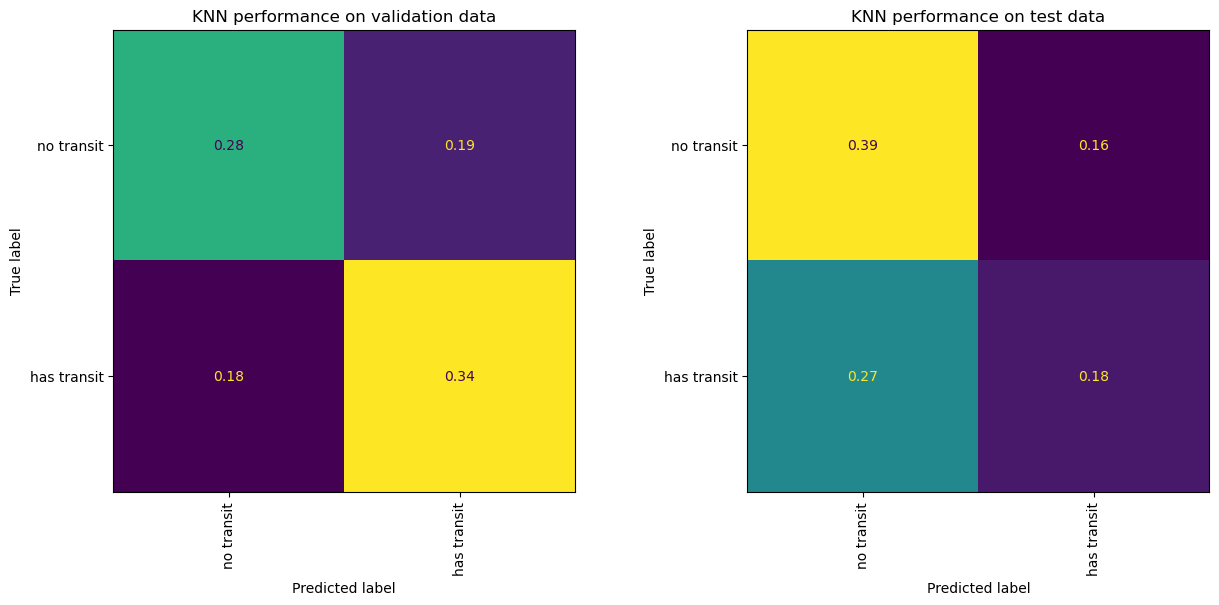

In [5]:

picked_n_neighbors = best_n_neighbors
knn = KNeighborsClassifier(picked_n_neighbors)
knn.fit(X_train_interp, y_train)
knn_pred_val = knn.predict(X_val_interp)
knn_pred_train = knn.predict(X_train_interp)

knn_pred_val = knn.predict(X_val_interp)
print('Validation Data:')
print('   Accuracy:', np.round(accuracy_score(y_val , knn_pred_val),3))
print('   Precision:', np.round(precision_score(y_val , knn_pred_val),3))
print('   Recall:', np.round(recall_score(y_val , knn_pred_val),3))
print('   F1:', np.round(f1_score(y_val , knn_pred_val),3))

knn_pred_test = knn.predict(X_test_interp)
print('Test Data:')
print('   Accuracy:', np.round(accuracy_score(y_test , knn_pred_test),3))
print('   Precision:', np.round(precision_score(y_test , knn_pred_test),3))
print('   Recall:', np.round(recall_score(y_test , knn_pred_test),3))
print('   F1:', np.round(f1_score(y_test , knn_pred_test),3))

fig, ax = plt.subplots(1,2, figsize=(15,6))
ax1 = plt.subplot(121)
ConfusionMatrixDisplay.from_estimator(knn, X_val_interp, y_val, xticks_rotation='vertical', ax=ax1, normalize = 'all', display_labels=['no transit','has transit'], colorbar=False)
#plot_confusion_matrix(knn, X_val, y_val, ax=ax, display_labels=['no transit','has transit'], xticks_rotation='vertical') # are the labels right??
plt.title('KNN performance on validation data')
ax2 = plt.subplot(122)
ConfusionMatrixDisplay.from_estimator(knn, X_test_interp, y_test, xticks_rotation='vertical', ax=ax2, normalize = 'all', display_labels=['no transit','has transit'], colorbar=False)
#plot_confusion_matrix(knn, X_val, y_val, ax=ax, display_labels=['no transit','has transit'], xticks_rotation='vertical') # are the labels right??
plt.title('KNN performance on test data')
plt.show()

# Algorithm 2: Random Forest

### Determine best hyperparameters


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:584: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:584: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:584: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:584: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:584: UserWarning: Some inputs do not have OOB scores. This probably means too fe

Optimal value: 25
   with validation accuracy: 0.6716417910447762


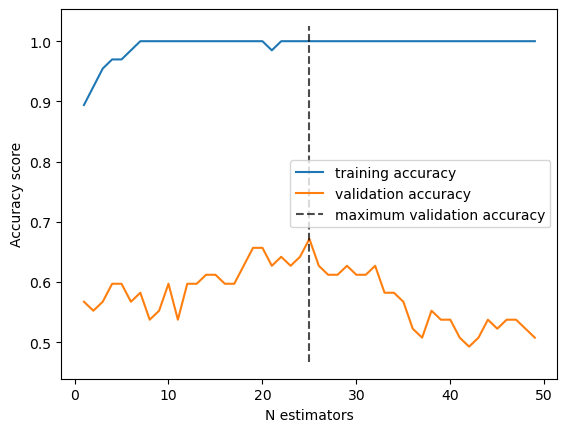

In [7]:
train_acc = []
val_acc = []
for n in np.arange(1,50,1):
    #print(n)
    rf = RandomForestClassifier(random_state=2021, n_estimators=n, max_depth=50, max_features=None, oob_score=True, class_weight = 'balanced')
    rf.fit(X_train_interp, y_train)
    rf_pred_val = rf.predict(X_val_interp)
    rf_pred_train = rf.predict(X_train_interp)
    train_acc += [accuracy_score(y_train,rf_pred_train)]
    val_acc += [accuracy_score(y_val,rf_pred_val)]
    
# determine 'best' hyperparameters
best_n_estimators = int(np.arange(1,50,1)[np.where(val_acc == np.max(val_acc))])
print('Optimal value: ' + str(best_n_estimators))
print('   with validation accuracy: ' + str(np.max(val_acc)))
plt.figure(dpi = 100)
plt.plot(np.arange(1,50,1),train_acc, label = 'training accuracy')
plt.plot(np.arange(1,50,1),val_acc,label = 'validation accuracy')
ylims = plt.gca().get_ylim()
plt.vlines(best_n_estimators, ylims[0], ylims[1], 'k', alpha = 0.7, linestyle = 'dashed', label = 'maximum validation accuracy')
plt.ylabel('Accuracy score')
plt.xlabel('N estimators')
plt.legend()

Validation Data:
   Accuracy: 0.672
   Precision: 0.651
   Recall: 0.8
   F1: 0.718
Test Data:
   Accuracy: 0.627
   Precision: 0.568
   Recall: 0.7
   F1: 0.627


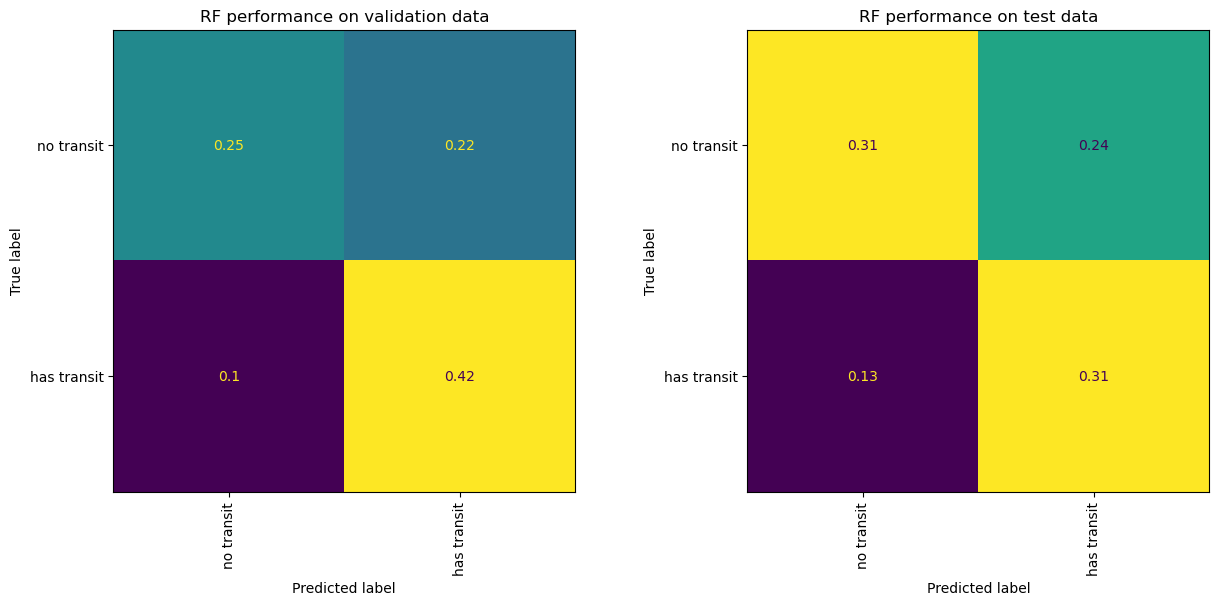

In [11]:
rf = RandomForestClassifier(random_state=2021, n_estimators=best_n_estimators, max_depth=50, max_features=None, oob_score=True, class_weight = 'balanced')
rf.fit(X_train_interp, y_train)
rf_pred_val = rf.predict(X_val_interp)
rf_pred_train = rf.predict(X_train_interp)
rf_pred_test = rf.predict(X_test_interp)
#train_acc += [accuracy_score(y_train,rf_pred_train)]
#val_acc += [accuracy_score(y_val,rf_pred_val)]
#test_acc += [accuracy_score(y_test,rf_pred_test)]
#print('train accuracy:', np.round(accuracy_score(y_train , rf_pred_train),4))
#print('validation accuracy, RF:', np.round(accuracy_score(y_val,rf_pred_val),4))
#print('test accuracy, RF:', np.round(accuracy_score(y_test,rf_pred_test),4))


rf_pred_val = rf.predict(X_val_interp)
print('Validation Data:')
print('   Accuracy:', np.round(accuracy_score(y_val , rf_pred_val),3))
print('   Precision:', np.round(precision_score(y_val , rf_pred_val),3))
print('   Recall:', np.round(recall_score(y_val , rf_pred_val),3))
print('   F1:', np.round(f1_score(y_val , rf_pred_val),3))

rf_pred_test = rf.predict(X_test_interp)
print('Test Data:')
print('   Accuracy:', np.round(accuracy_score(y_test , rf_pred_test),3))
print('   Precision:', np.round(precision_score(y_test , rf_pred_test),3))
print('   Recall:', np.round(recall_score(y_test , rf_pred_test),3))
print('   F1:', np.round(f1_score(y_test , rf_pred_test),3))

fig, ax = plt.subplots(1,2, figsize=(15,6))
ax1 = plt.subplot(121)
ConfusionMatrixDisplay.from_estimator(rf, X_val_interp, y_val, xticks_rotation='vertical', ax=ax1, normalize = 'all', display_labels=['no transit','has transit'], colorbar=False)
#plot_confusion_matrix(knn, X_val, y_val, ax=ax, display_labels=['no transit','has transit'], xticks_rotation='vertical') # are the labels right??
plt.title('RF performance on validation data')
ax2 = plt.subplot(122)
ConfusionMatrixDisplay.from_estimator(rf, X_test_interp, y_test, xticks_rotation='vertical', ax=ax2, normalize = 'all', display_labels=['no transit','has transit'], colorbar=False)
#plot_confusion_matrix(knn, X_val, y_val, ax=ax, display_labels=['no transit','has transit'], xticks_rotation='vertical') # are the labels right??
plt.title('RF performance on test data')
plt.show()

# Algorithm 3: Logistic Regression

Optimal value: [0.5302004]
   with validation accuracy: 0.5522388059701493


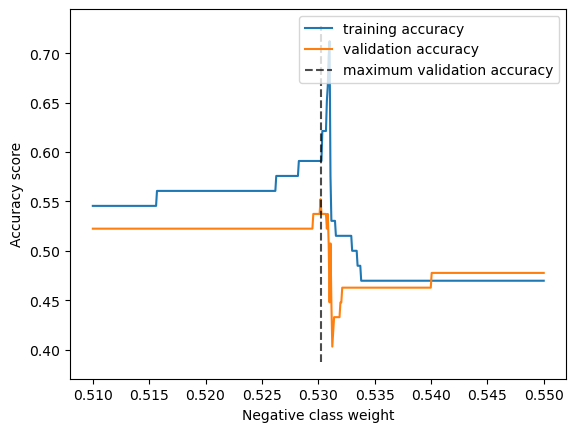

In [55]:
train_acc = []
val_acc = []
w_arr = np.linspace(0.51,0.55,500)
for w_neg in w_arr:
    #print(n)
    w_pos = 1-w_neg
    w = {0:w_neg, 1:w_pos} 
    LR = LogisticRegression(random_state=123, class_weight=w, max_iter = 10000)
    LR.fit(X_train_interp,y_train)
    LR_pred_val = LR.predict(X_val_interp)
    LR_pred_train = LR.predict(X_train_interp)
    train_acc += [accuracy_score(y_train,LR_pred_train)]
    val_acc += [accuracy_score(y_val,LR_pred_val)]
    
# determine 'best' hyperparameters
best_w_neg = w_arr[np.where(val_acc == np.max(val_acc))]
print('Optimal value: ' + str(best_w_neg))
print('   with validation accuracy: ' + str(np.max(val_acc)))
plt.figure(dpi = 100)
plt.plot(w_arr,train_acc, label = 'training accuracy')
plt.plot(w_arr,val_acc,label = 'validation accuracy')
ylims = plt.gca().get_ylim()
plt.vlines(best_w_neg, ylims[0], ylims[1], 'k', alpha = 0.7, linestyle = 'dashed', label = 'maximum validation accuracy')
plt.ylabel('Accuracy score')
plt.xlabel('Negative class weight')
plt.legend()

Validation Data:
   Accuracy: 0.552
   Precision: 0.538
   Recall: 1.0
   F1: 0.7
Test Data:
   Accuracy: 0.507
   Precision: 0.476
   Recall: 1.0
   F1: 0.645


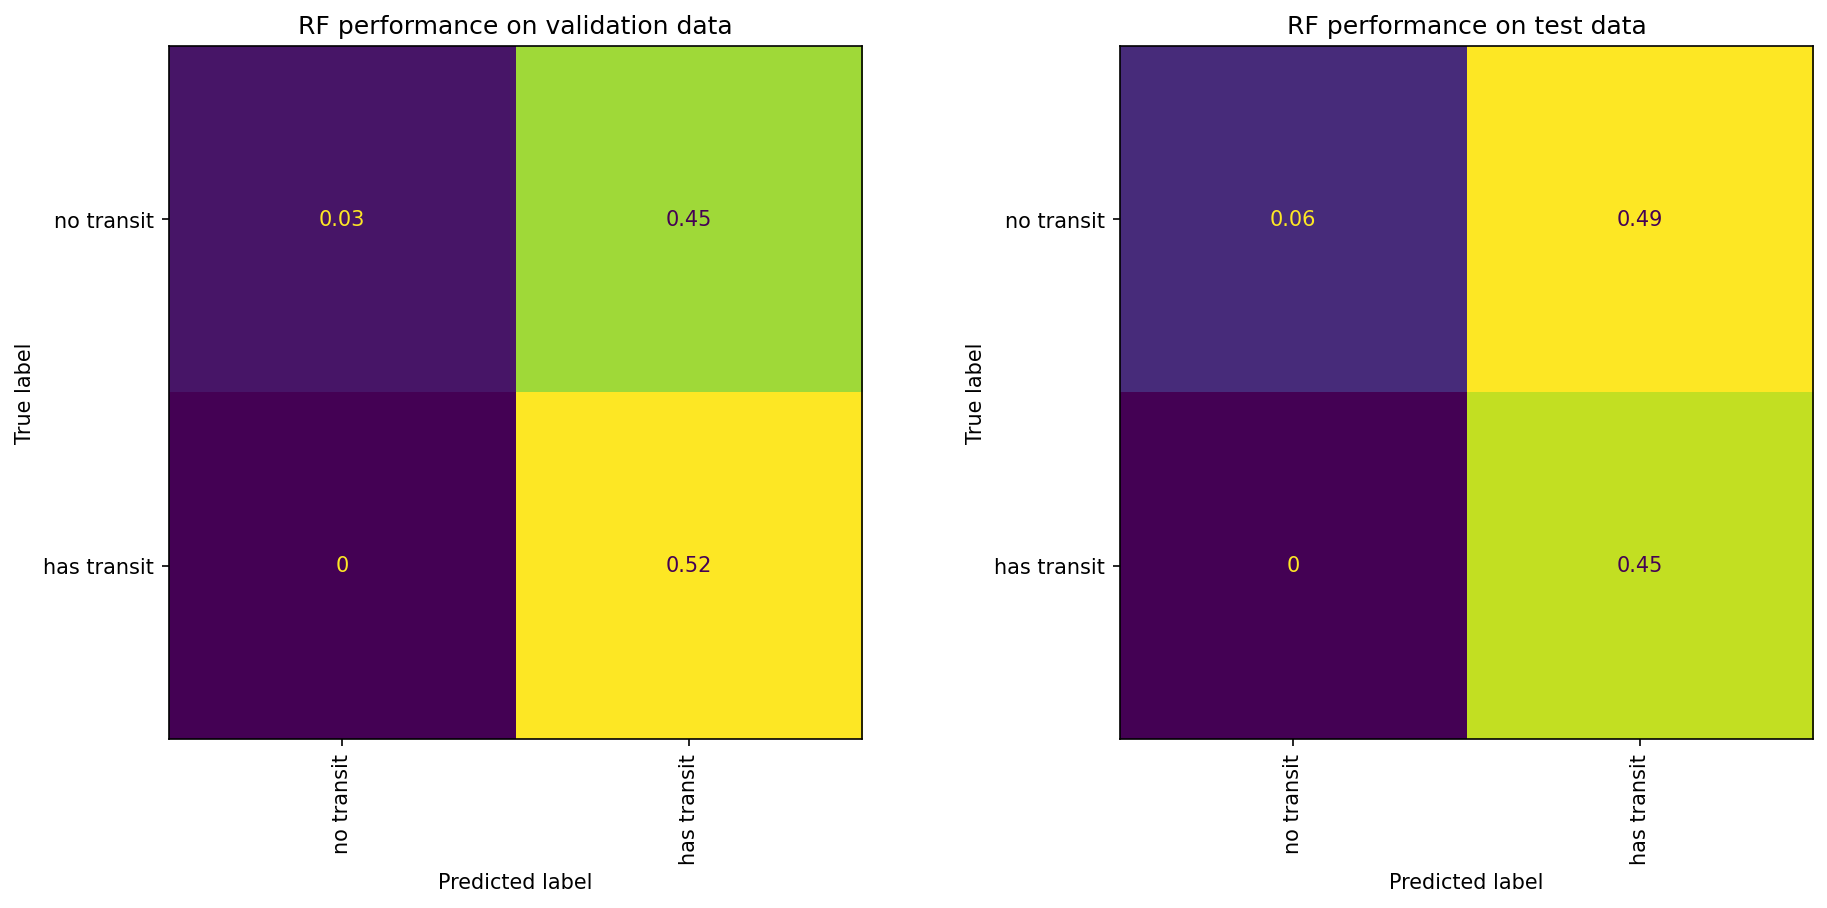

In [57]:
# Weights determined iteratively, but no good set of weights was found
w_neg = best_w_neg
w_pos = 1-w_neg
w = {0:w_neg, 1:w_pos} 

LR = LogisticRegression(random_state=123, class_weight=w, max_iter = 10000)
LR.fit(X_train_interp,y_train)

lr_pred_train = LR.predict(X_train_interp)
lr_pred_val = LR.predict(X_val_interp)
lr_pred_test = LR.predict(X_test_interp)
#print('train accuracy:', np.round(accuracy_score(y_train , lr_pred_train),4))
#print('validation accuracy, RF:', np.round(accuracy_score(y_val,lr_pred_val),4))
#print('test accuracy, RF:', np.round(accuracy_score(y_test,lr_pred_test),4))

lr_pred_val = LR.predict(X_val_interp)
print('Validation Data:')
print('   Accuracy:', np.round(accuracy_score(y_val , lr_pred_val),3))
print('   Precision:', np.round(precision_score(y_val , lr_pred_val),3))
print('   Recall:', np.round(recall_score(y_val , lr_pred_val),3))
print('   F1:', np.round(f1_score(y_val , lr_pred_val),3))

lr_pred_test = LR.predict(X_test_interp)
print('Test Data:')
print('   Accuracy:', np.round(accuracy_score(y_test , lr_pred_test),3))
print('   Precision:', np.round(precision_score(y_test , lr_pred_test),3))
print('   Recall:', np.round(recall_score(y_test , lr_pred_test),3))
print('   F1:', np.round(f1_score(y_test , lr_pred_test),3))

# plot confusion matrix on validation set
fig, ax = plt.subplots(1,2, figsize=(15,6), dpi = 150)
ax1 = plt.subplot(121)
ConfusionMatrixDisplay.from_estimator(LR, X_val_interp, y_val, xticks_rotation='vertical', ax=ax1, normalize = 'all', display_labels=['no transit','has transit'], colorbar = False)
plt.title('RF performance on validation data')
ax2 = plt.subplot(122)
ConfusionMatrixDisplay.from_estimator(LR, X_test_interp, y_test, xticks_rotation='vertical', ax=ax2, normalize = 'all', display_labels=['no transit','has transit'], colorbar = False)
plt.title('RF performance on test data')
plt.show()